In [1]:
import h5py
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections
from matplotlib import image
 
from math import *;

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\code\\myPy')  
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
sys.path.append('C:\\Users\\Vandiver\\Documents\\HiFU\\code\\BioHeatCpp\\PBHEswig\\x64')
import ablation_utils
import geom
import sonalleve
import transducers
import PBHEswig
from countlines import countlines


%matplotlib inline

In [2]:
def sonication_heating(Iavg, CEM, duration, T0=None, CEMinit=None, Tmax=None):
    Tdot[:] = 2.0*(alpha_acc)*Iavg / (rho*c0)
    if T0 is not None:
        T[:] = T0
    if CEMinit is not None:
        CEM[:]=CEMinit
    if Tmax is None:
        Tmax = np.zeros_like(CEM)
    else:
        Tmax[:]=0
    
    time=0
    ti=0
    buffsize=T.shape[0]
    tstep=dt*buffsize
    while time<duration :

        print( '%d%%' % (time/duration *100.0), end='\r')
        
        if (time + tstep > duration):
            buffsize = ceil((duration-time)/dt)
            tstep = dt*buffsize
            

        PBHEswig.pbheSolve(0,dt,dx,dy,dz, Tmesh, Tdotmesh, kmesh, rhoCpmesh, 37.0, perfRate,0,buffsize-1 )
        Rbase[:]=4
        Rbase[np.where(T[0:,buffsize] > 43.0, True, False)] = 2
        
        update = np.where(T[buffsize-1] > Tmax, True, False)
        Tmax[update] = T[buffsize-1][update]

                #time integrate to get the thermal dose
        CEM[:] += (dt/60.0)*np.sum( Rbase**(T[0:buffsize]-43), 0  )

        ti+=1
        time+=tstep
        T[0] = T[buffsize-1]
        
    return (Tmax, time)

In [3]:
uxyz = sonalleve.get_sonalleve_xdc_vecs()
f0=1.2e6
c0=1540
k0=2*pi*f0/c0

uamp = np.ones_like(uxyz[:,0])

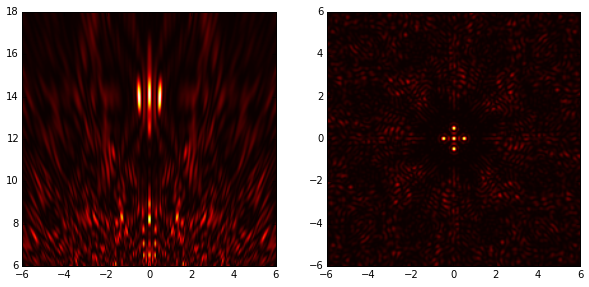

In [5]:
xp=np.linspace(-6,6,200)
yp=[0.0]
zp=np.linspace(6.0, 18.0, 200)

d=0.005;


pxyz=geom.cross(d,z=0.14)

p0 = 1e7*np.ones(len(pxyz));

uamp1 = transducers.get_focused_element_vals(k0, uxyz, pxyz, p0 )

Pxz=np.squeeze ( transducers.calc_pressure_field(k0, uxyz , uamp1, 0.01*xp, yp, 0.01*zp) )
Pxy=np.squeeze ( transducers.calc_pressure_field(k0, uxyz , uamp1, 0.01*xp, 0.01*xp, [0.14]) )

Ixz = np.abs(Pxz)**2
Ixy = np.abs(Pxy)**2

minPlot=np.min(Ixz)
maxPlot=np.max(Ixz)

fig=plt.figure(figsize=(10,7), dpi=72)
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.imshow(np.transpose( Ixz ),vmin=minPlot,vmax=maxPlot,cmap=image.cm.hot, origin='lower', extent=[xp[0],xp[-1], zp[0], zp[-1]])
ax2.imshow(np.transpose( Ixy ),vmin=minPlot,vmax=maxPlot,cmap=image.cm.hot, origin='lower', extent=[xp[0],xp[-1], xp[0], xp[-1]])


In [6]:
Nx = 65
Ny = 65
Nz = 41
Nt = 6

xrp = 1e-2*np.linspace(-2,2,Nx)
yrp = 1e-2*np.linspace(-2,2,Ny)
zrp = 1e-2*np.linspace(10,17,Nz)

dx = xrp[1]-xrp[0]
dy = yrp[1]-yrp[0]
dz = zrp[1]-zrp[0]

dt = 0.1
res = np.array([dt,dx,dy,dz])
voxVol=dx*dy*dz

zplane=0.14
focplaneZpix=np.where(np.logical_and( (zrp[1:-1]-zplane>=0) , (zrp[0:-2]-zplane<0) ))[0][0]

zSelectors = [[0.105,0.115],[0.115,0.125],[0.125,0.135],[.135,.145],[.145,.155], [.155,.165]]
whichOneIsFoc=3
def get_zindx(z):
    return np.where(np.logical_and( (zrp[0:-2]- z[0] >=0) , (zrp[1:-1]-z[1]<=0) ))[0]

zSectorIndcs = list(map(get_zindx, zSelectors))
xSectorIndcs = np.where(np.logical_and( (xrp[0:-2] >= -0.005) , (xrp[1:-1] <= 0.005) ))[0]
ySectorIndcs = np.where(np.logical_and( (yrp[0:-2] >= -0.005) , (yrp[1:-1] <= 0.005) ))[0]

roiFocZ = zSectorIndcs[whichOneIsFoc]

sectorx,sectory=np.meshgrid(xSectorIndcs, ySectorIndcs, indexing='ij')

In [7]:
# ----- allocate numpy data arrays --- #
T = np.zeros([Nt,Nx,Ny,Nz])
Tdot = np.zeros([Nx,Ny,Nz])
kdiff = np.zeros([Nx,Ny,Nz])
rhoCp = np.zeros([Nx,Ny,Nz])

# ---- Create C++ mesh objects ---
Tmesh = PBHEswig.mesh4d()
Tdotmesh = PBHEswig.mesh34d();
kmesh = PBHEswig.mesh3d();
rhoCpmesh = PBHEswig.mesh3d();

# ----- tie data arrays to mesh objects (to pass to C++) ---
# the data in each mesh can now be accessed/manipulated from python via the arrays, 'T', 'Tdot', etc.
PBHEswig.ShareMemoryMesh4(T, res, Tmesh)
PBHEswig.ShareMemoryMesh34(Tdot, res, Tdotmesh)
PBHEswig.ShareMemoryMesh3(kdiff, res[1:4], kmesh)
PBHEswig.ShareMemoryMesh3(rhoCp, res[1:4], rhoCpmesh)

In [201]:
del Tmesh,Tdotmesh,kmesh,rhoCpmesh, T,Tdot,kdiff,rhoCp

In [8]:
CEM0 = np.zeros([Nx,Ny,Nz])
CEM1 = np.zeros([Nx,Ny,Nz])
Rbase = np.zeros([Nx,Ny,Nz])

In [9]:
#initial conditions
rho=3700
T[:] = 37.0
Tdot[:] = 0;
kdiff[:] = 0.5;
rhoCp[:] = rho*1000;

perfRate = 0.01;
alpha_acc = 0.5;

In [10]:
N = uxyz.shape[0]

Ispta0 = 2.5e7;

uamp0 = np.ones(N) / N

P0 = sonalleve.calc_pressure_field(k0, uxyz, uamp0, xrp, yrp, zrp)
I0 = np.abs(P0)**2 / (2.0*rho*c0)

powerRenorm = (Ispta0/np.max(I0))
I0 *= powerRenorm

#update uamp0
uamp0 *= sqrt(powerRenorm)

In [9]:
CEM1[:]=0
T[0,:]=37

In [11]:
def calc_multifoc_field(d, Ispta1=None):

    pxyz=geom.cross(d,z=0.14)

    p0 = 1e7*np.ones(len(pxyz));

    uamp1 = transducers.get_focused_element_vals(k0, uxyz, pxyz, p0 )

    uamp1renorm = sqrt(powerRenorm)*( uamp1  ) / sum(abs(uamp1))

    P1 = sonalleve.calc_pressure_field(k0, uxyz, uamp1renorm, xrp, yrp, zrp)
    I1 = np.abs(P1)**2 / (2.0*rho*c0)
    if Ispta1 is not None:
        I1 *= (Ispta1/np.max(I1))
    return I1

In [303]:
d=0.001
I1 = calc_multifoc_field(d)

In [12]:
np.arange(0.001,0.0075,0.001)

array([ 0.001,  0.002,  0.003,  0.004,  0.005,  0.006,  0.007])

In [22]:
dlist = np.arange(0.001,0.006,0.0005)

TmRatios = np.zeros([len(dlist), len(zSelectors)])
TmAvgRatios = np.zeros([len(dlist), len(zSelectors)])
I1Ratios = np.zeros([len(dlist), len(zSelectors)])
Tmaxes = np.zeros([len(dlist), len(zSelectors)])
TmaxAvgs = np.zeros([len(dlist), len(zSelectors)])
di=0
for d in dlist:
    print(d, end=' ')
    I1 = calc_multifoc_field(d)
    Tmax, endtime = sonication_heating(I1, CEM1, 60.0, CEMinit=0, T0=37 )
    
    Tmaxes[di] = np.array(list( map( lambda zlist: np.max( Tmax[sectorx,sectory,zlist[0]:zlist[-1]] ), zSectorIndcs )) )
    TmaxAvgs[di] = np.array(list( map( lambda zlist: np.mean( Tmax[sectorx,sectory,zlist[0]:zlist[-1]] ), zSectorIndcs )) )
    TmRatios[di] = Tmaxes[di] / Tmaxes[di, whichOneIsFoc]
    TmAvgRatios[di] = TmaxAvgs[di] / TmaxAvgs[di, whichOneIsFoc]
    I1Ratios[di] =  list( map( lambda zlist: np.mean( I1[sectorx,sectory,zlist[0]:zlist[-1]] ), zSectorIndcs ) ) 
    I1Ratios[di] /= I1Ratios[di, whichOneIsFoc]
    di+=1


endtime

60.0000000000001

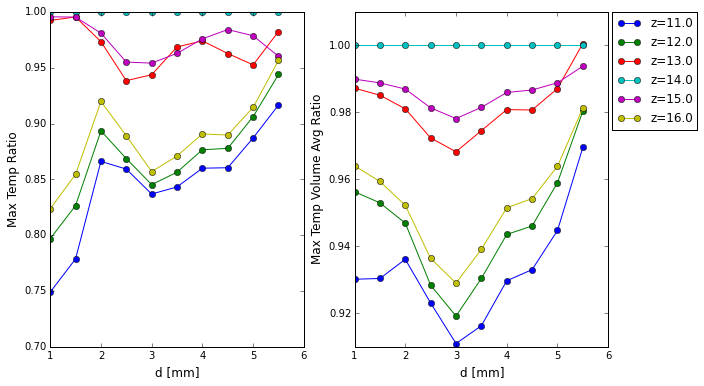

In [23]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot( 1000*dlist,TmRatios, '-o')
plt.xlabel('d [mm]',fontsize=12)
plt.ylabel('Max Temp Ratio',fontsize=12)
plt.subplot(122)
plt.plot( 1000*dlist,TmAvgRatios, '-o')
plt.xlabel('d [mm]',fontsize=12)
plt.ylabel('Max Temp Volume Avg Ratio',fontsize=12)
plt.legend(list(map(lambda x: 'z=%0.1f' % (50.0*(x[0]+x[1])),zSelectors  )), bbox_to_anchor=(1.35, 1), borderaxespad=0.)

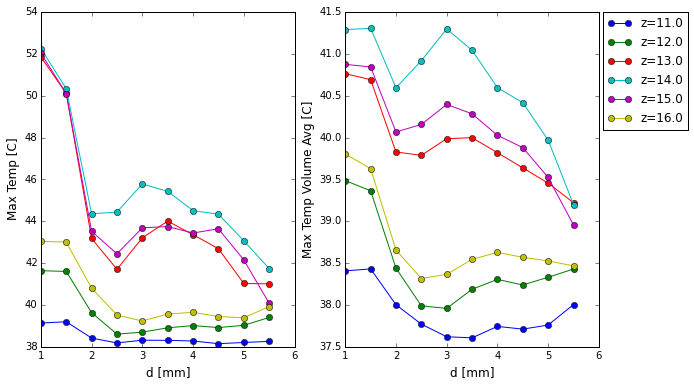

In [24]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot( 1000*dlist,Tmaxes, '-o')
plt.xlabel('d [mm]',fontsize=12)
plt.ylabel('Max Temp [C]',fontsize=12)
plt.subplot(122)
plt.plot( 1000*dlist,TmaxAvgs, '-o')
plt.xlabel('d [mm]',fontsize=12)
plt.ylabel('Max Temp Volume Avg [C]',fontsize=12)
plt.legend(list(map(lambda x: 'z=%0.1f' % (50.0*(x[0]+x[1])),zSelectors  )), bbox_to_anchor=(1.35, 1), borderaxespad=0.)


In [25]:
tlist = np.arange(5.0, 90.0,5.0)

TmRatios = np.zeros([len(tlist), len(zSelectors)])
TmAvgRatios = np.zeros([len(tlist), len(zSelectors)])
I1Ratios = np.zeros([len(zSelectors)])
Tmaxes = np.zeros([len(tlist), len(zSelectors)])
TmaxAvgs = np.zeros([len(tlist), len(zSelectors)])
ti=0

d = 0.0035
I1 = calc_multifoc_field(d)

I1Ratios =  list( map( lambda zlist: np.mean( I1[sectorx,sectory,zlist[0]:zlist[-1]] ), zSectorIndcs ) ) 
I1Ratios /= I1Ratios[whichOneIsFoc]

endtime=0.0
CEM1[:]=0
T[0][:]=37
tprev=0
for t in tlist:
    print(t, end=' ')
    duration = t-tprev
    
    Tmax, endtime = sonication_heating(I1, CEM1, duration )
    
    tprev += endtime
    
    Tmaxes[ti] = np.array(list( map( lambda zlist: np.max( Tmax[sectorx,sectory,zlist[0]:zlist[-1]] ), zSectorIndcs )) )
    TmaxAvgs[ti] = np.array(list( map( lambda zlist: np.mean( Tmax[sectorx,sectory,zlist[0]:zlist[-1]] ), zSectorIndcs )) )
    TmRatios[ti] = Tmaxes[ti] / Tmaxes[ti, whichOneIsFoc]
    TmAvgRatios[ti] = TmaxAvgs[ti] / TmaxAvgs[ti, whichOneIsFoc]
    del Tmax
    
    ti+=1

In [26]:
TmAvgRatios.shape

(17, 6)

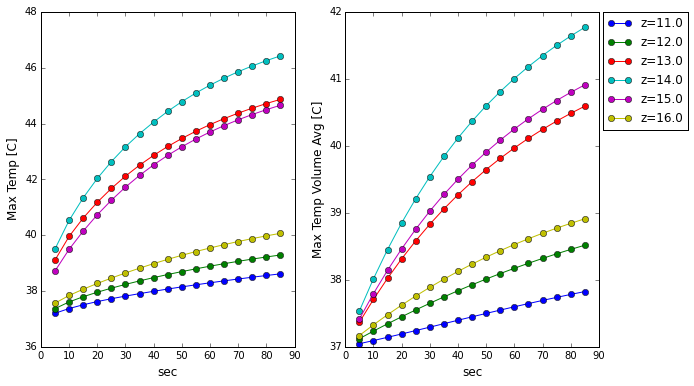

In [28]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot( tlist,Tmaxes, '-o')
plt.xlabel('sec',fontsize=12)
plt.ylabel('Max Temp [C]',fontsize=12)
plt.subplot(122)
plt.plot( tlist,TmaxAvgs, '-o')
plt.xlabel('sec',fontsize=12)
plt.ylabel('Max Temp Volume Avg [C]',fontsize=12)
plt.legend(list(map(lambda x: 'z=%0.1f' % (50.0*(x[0]+x[1])),zSelectors  )), bbox_to_anchor=(1.35, 1), borderaxespad=0.)

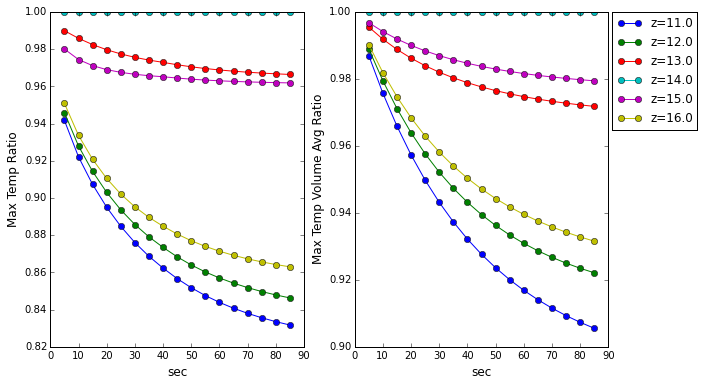

In [29]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot( tlist,TmRatios, '-o')
plt.xlabel('sec',fontsize=12)
plt.ylabel('Max Temp Ratio',fontsize=12)
plt.subplot(122)
plt.plot( tlist,TmAvgRatios, '-o')
plt.xlabel('sec',fontsize=12)
plt.ylabel('Max Temp Volume Avg Ratio',fontsize=12)
plt.legend(list(map(lambda x: 'z=%0.1f' % (50.0*(x[0]+x[1])),zSelectors  )), bbox_to_anchor=(1.35, 1), borderaxespad=0.)

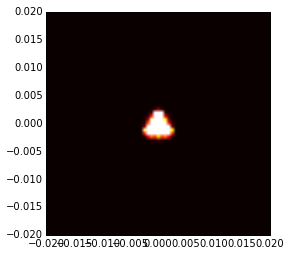

In [35]:
plt.imshow(np.transpose( CEM1[:,:,focplaneZpix] ),vmin=0,vmax=240,cmap=image.cm.hot, origin='lower', extent=[xrp[0],xrp[-1], xrp[0], xrp[-1]])

In [40]:
h5name = "C:\\Users\\Vandiver\\Documents\\HiFU\\code\\AblationSims\\focal_point_opt\\cem_3.5_I=3500_t=90.hdf5"

f = h5py.File(h5name, "w")
dset = f.create_dataset("CEM", data=CEM1)

dset.attrs['xp']=xrp
dset.attrs['zp']=zrp
dset.attrs['yp']=yrp

dset.attrs['cem240VolROI']=[0,0]
dset.attrs['times']=tlist
dset.attrs['Ispta0']=Ispta0
dset.attrs['Ispta']=np.max(I1)

f.close()